# I. Introduction

This exercise implements a KNN algorithm 'from scratch' and explores possible k-values as well as different tie-breaker solutions for the iris dataset from scikit-learn.

First we import helpful packages.

In [2]:
import numpy as np
from sklearn import datasets
import pandas as pd
from heapq import nsmallest
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# II. Loading & Exploring the Data

Then we load the iris dataset from scikit-learn, convert it into a pandas Dataframe for easier manipulation, and determine the number of each 'target' value.

In [4]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
iris_df['target'].value_counts()

2.0    50
1.0    50
0.0    50
Name: target, dtype: int64

Before we implement the KNN algorithm, let's first take a look at target classification by sets of our predictors.

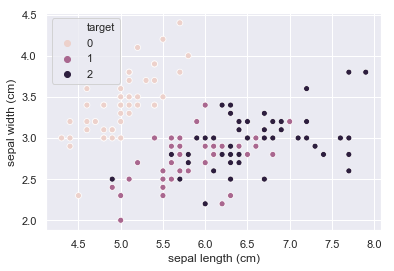

In [6]:
iris_df["target"] = iris_df["target"].astype(int)
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data = iris_df, x = 'sepal length (cm)', y = 'sepal width (cm)', hue = 'target')

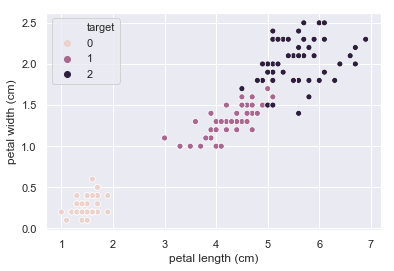

In [7]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data = iris_df, x = 'petal length (cm)', y = 'petal width (cm)', hue = 'target')

The plots indicate that KNN would be a good algorithm to employ on this data due to the high-level of grouping of similar colors ('target' values).

# III. Defining KNN

Our KNN algorithm was implemented with the use of smaller helper functions.

First, we know that we'll need to calculate distances between any 2 records from the iris dataset, so first we create a distance function which takes in two pandas series of predictor variables (derived from Dataframe rows) and returns the 'distance' between them.

In [8]:
def sarahs_dist_formula(rec1, rec2):
    diff = rec1 - rec2
    squared = diff**2
    summed = sum(squared)
    return np.sqrt(summed)

And now for a quick spot check test...

In [9]:
print(sarahs_dist_formula(iris_df.iloc[1,:4], iris_df.iloc[1,:4]))
print(sarahs_dist_formula(iris_df.iloc[1,:4], iris_df.iloc[2,:4]))

0.0
0.30000000000000016


Looks good.

Next, we'll need a complete 'distance matrix' that stores the distances between all pairs of records.  We chose to store these distances in a nested dictionary for easy future lookups.

In [10]:
def sarahs_dist_dict(predictors):
    dist_dict = {}
    # first creates the nested dictionaries so we can store the distances as we calculate them
    for record in predictors.index:
        dist_dict[record] = {}
    # cycles through each combination of different records, calculates the distance and stores it in both appropriate locations
    for record1 in predictors.index:
        for record2 in predictors[record1+1:].index:
            dist = sarahs_dist_formula(predictors.iloc[record1], predictors.iloc[record2])
            dist_dict[record1][record2] = dist
            dist_dict[record2][record1] = dist
    return dist_dict

Again, a quick spot check test...

In [11]:
temp = sarahs_dist_dict(iris_df.iloc[:,:4])
temp_df = pd.DataFrame(temp)
print(temp_df.shape)
temp_df.head()

(150, 150)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,NaN,0.538516,0.509902,0.648074,0.141421,0.616441,0.519615,0.173205,0.921954,0.469042,...,5.019960,4.636809,4.208325,5.257376,5.136146,4.654031,4.276681,4.459821,4.650806,4.140048
1,0.538516,NaN,0.300000,0.331662,0.608276,1.090871,0.509902,0.424264,0.509902,0.173205,...,5.072475,4.702127,4.180909,5.320714,5.206726,4.700000,4.249706,4.498889,4.718050,4.153312
2,0.509902,0.300000,NaN,0.244949,0.509902,1.086278,0.264575,0.412311,0.435890,0.316228,...,5.228767,4.868265,4.334743,5.475400,5.353504,4.864155,4.430576,4.661545,4.848711,4.298837
3,0.648074,0.331662,0.244949,NaN,0.648074,1.166190,0.331662,0.500000,0.300000,0.316228,...,5.104900,4.760252,4.177320,5.349766,5.232590,4.745524,4.288356,4.533211,4.719110,4.149699
4,0.141421,0.608276,0.509902,0.648074,NaN,0.616441,0.458258,0.223607,0.921954,0.529150,...,5.061620,4.686150,4.246175,5.297169,5.173007,4.701064,4.330127,4.504442,4.678675,4.173727


Looks good.

Next, we know we'll need to determine the appropriate target value prediction for each individual record.  The next two functions take in the distance dictionary for a single record (via index), the full 'target' pandas series, and the k-value we want the prediction to be based on.

In rare cases, but particularly with 3 classification values, there may be ties for which 'target' class has the highest presence among a record's k nearest neighbors.  We implement two versions for resolving the tie.
1. Version 1 implements a recursive(!) solution and re-calculates the max count class with k+1 neighbors
2. Version 2 sums the distances for each of the target classes with the equally highest counts among the k nearest neighbors and picks the class with the smallest total distance among the same k neighbors

We'll explore both versions when running our KNN algorithms and investigating the results.

In [12]:
def sarahs_knn_single_prediction_v1(records_dict, target, k):
    indeces = nsmallest(k, records_dict, key = records_dict.get)
    class_counts = target[indeces].value_counts()
    if len(class_counts[class_counts==class_counts.max()]) > 1:
        new_guess = sarahs_knn_single_prediction_v1(records_dict, target, k+1) #ooo recursion!
        return new_guess
    else:
        return class_counts.idxmax()

In [13]:
def sarahs_knn_single_prediction_v2(records_dict, target, k):
    indeces = nsmallest(k, records_dict, key = records_dict.get)
    class_counts = target[indeces].value_counts()
    if len(class_counts[class_counts==class_counts.max()]) > 1:
        # first we filter the class counts to only those with equally 'max' counts
        val_class_count = class_counts[class_counts==class_counts.max()]
        # then we filter the indeces of the neighbors to only those with those highest class counts
        filtered_targs = target[indeces][target[indeces].isin(list(val_class_count.index))]
        filtered_indeces = list(filtered_targs.index)
        # next we create a mini dictionary of only those indeces and their distances with the record we're trying to predict...
        dists = {ind:records_dict[ind] for ind in filtered_indeces}
        # and convert it to a pandas Dataframe for easier manipulation
        dists = pd.DataFrame.from_dict(dists, orient='index', columns = ['dist_value'])
        # we joins this Dataframe of distance values with the corresponding indeces 'target' values
        tot = dists.join(target[indeces])
        # sum the distances by target value
        tot_summed = tot.groupby('target').sum()
        # determin the minimum distance
        tot_summed_min_dist = min(tot_summed['dist_value'])
        # and find the target value with that minimum distance
        new_guess = tot_summed[tot_summed['dist_value'] == tot_summed_min_dist].index[0]
        return new_guess
    else:
        return class_counts.idxmax()

Another quick spot check test... 

Through data exploration, we determined that when k = 4, running the basic knn algorithm on the record at index 133 results in a tie between target classes '1' and '2'.  Thus, we use this index as our test case.

In [14]:
test_indeces = nsmallest(4, temp[133], key = temp[133].get)
test_class_counts = iris_df.loc[:, 'target'][test_indeces].value_counts()
test_class_counts

2    2
1    2
Name: target, dtype: int64

In [15]:
print(sarahs_knn_single_prediction_v1(temp[133], iris_df.loc[:, 'target'], 4))
print(sarahs_knn_single_prediction_v2(temp[133], iris_df.loc[:, 'target'], 4))

2
1


Interesting!  In this case, our two tie-breaker solutions yield different results!

Lastly, we wrap our helper functions into two comprehensive knn solution functions -- one for each tie-breaker method -- which both take a Dataframe of predictors, the outcome variable Series, and a k value, and return a list (in order) of predicted classes.

In [16]:
def sarahs_knn_v1(predictors, outcome, k):
    dist_dict = sarahs_dist_dict(predictors)
    predictions = []
    for record in dist_dict.keys():
        predictions.append(sarahs_knn_single_prediction_v1(dist_dict[record], outcome, k))
    return predictions

def sarahs_knn_v2(predictors, outcome, k):
    dist_dict = sarahs_dist_dict(predictors)
    predictions = []
    for record in dist_dict.keys():
        predictions.append(sarahs_knn_single_prediction_v2(dist_dict[record], outcome, k))
    return predictions

In [17]:
# just to help demonstrate testing
from collections import Counter

v1_results = sarahs_knn_v1(iris_df.iloc[:,:4], iris_df['target'], 4)
v2_results = sarahs_knn_v2(iris_df.iloc[:,:4], iris_df['target'], 4)

print(Counter(v1_results))
print(Counter(v2_results))

Counter({2: 51, 0: 50, 1: 49})
Counter({0: 50, 1: 50, 2: 50})


Given that we know the three target classes all appear 50 times in the actual data, these results (on the surface) look pretty reasonable!

# IV. Running KNN and Organizing the Results

Now that our KNN algorithms have been instantiated, we can run them for any k-values we choose and append the results as new columns in our iris Dataframe.  For demonstration purposes, we'll run them for a wide range of k values.

__Please note!:__  This code may take a while to run.  If you'd like the following code to finish quicker, limit the 'range' values in the for loop below.

In [18]:
iris_df_results = iris_df

for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    iris_df_results[v1_string] = sarahs_knn_v1(iris_df.iloc[:,:4], iris_df['target'], k_val)
    iris_df_results[v2_string] = sarahs_knn_v2(iris_df.iloc[:,:4], iris_df['target'], k_val)

iris_df_results.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,v1_k_is_1,v2_k_is_1,v1_k_is_2,v2_k_is_2,v1_k_is_3,...,v1_k_is_71,v2_k_is_71,v1_k_is_72,v2_k_is_72,v1_k_is_73,v2_k_is_73,v1_k_is_74,v2_k_is_74,v1_k_is_75,v2_k_is_75
0,5.1,3.5,1.4,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.9,3.0,1.4,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,3.2,1.3,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.6,3.1,1.5,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,3.6,1.4,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we've captured the KNN predictions, what we really care about is the accuracy of each run of the algorithm, not necessarily the predictions themselve.  As such, we convert all the newly created columns to booleans representing whether our prediction was correct or not.

In [19]:
for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    iris_df_results[v1_string] = iris_df_results[v1_string] == iris_df_results['target']
    iris_df_results[v2_string] = iris_df_results[v2_string] == iris_df_results['target']

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,v1_k_is_1,v2_k_is_1,v1_k_is_2,v2_k_is_2,v1_k_is_3,...,v1_k_is_71,v2_k_is_71,v1_k_is_72,v2_k_is_72,v1_k_is_73,v2_k_is_73,v1_k_is_74,v2_k_is_74,v1_k_is_75,v2_k_is_75
0,5.1,3.5,1.4,0.2,0,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,4.9,3.0,1.4,0.2,0,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,4.7,3.2,1.3,0.2,0,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,4.6,3.1,1.5,0.2,0,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,5.0,3.6,1.4,0.2,0,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


We now have a record of whether each individual record was correctly or incorrectly predicted with each run of the algorithm(s).  To calculate overall accuracy of each run, we create a new 'results' dictionary.  For each k value, we capture that k-value, the accuracy of the 'V1' algorithm, and the accuracy of the 'V2' algorithm.

In [20]:
df_len = len(iris_df_results)
results_dict = {}
for k_val in range(1,76):
    v1_string = 'v1_' + 'k_is_' + str(k_val)
    v2_string = 'v2_' + 'k_is_' + str(k_val)
    results_dict[k_val] = [k_val, sum(iris_df_results[v1_string])/df_len, sum(iris_df_results[v2_string])/df_len]

[results_dict[x] for x in range(1,11)]

[[1, 0.96, 0.96],
 [2, 0.96, 0.96],
 [3, 0.96, 0.96],
 [4, 0.9666666666666667, 0.96],
 [5, 0.9666666666666667, 0.9666666666666667],
 [6, 0.9666666666666667, 0.96],
 [7, 0.9666666666666667, 0.9666666666666667],
 [8, 0.9666666666666667, 0.9666666666666667],
 [9, 0.9666666666666667, 0.9666666666666667],
 [10, 0.9733333333333334, 0.9533333333333334]]

Lastly, we convert the dictionary of results into pandas dataframe for easier exploration and visualization.

In [21]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['k_value', 'V1','V2'])
results_df.head()

,k_value,V1,V2
1,1,0.960000,0.960000
2,2,0.960000,0.960000
3,3,0.960000,0.960000
4,4,0.966667,0.960000
5,5,0.966667,0.966667


# V. Results Exploration & Discussion

In order to graph the accuracies side by side, we first 'melt' the dataframe, doubling the number of rows and adding a column to indicate which KNN version the accuracy metric is derived from.

In [22]:
results_melted = pd.melt(results_df, id_vars='k_value', var_name="Version", value_vars=['V1','V2'], value_name="Accuracy")
results_melted.head()

,k_value,Version,Accuracy
0,1,V1,0.960000
1,2,V1,0.960000
2,3,V1,0.960000
3,4,V1,0.966667
4,5,V1,0.966667


Here we plot two lines representing the accuracies from the two KNN algorithms by the k value chosen.

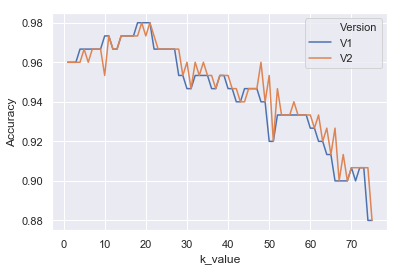

In [23]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted)

Clearly accuracies start to drop off as k increases past 20.

Let's filter the data frame to lower values of k to get a closer look.

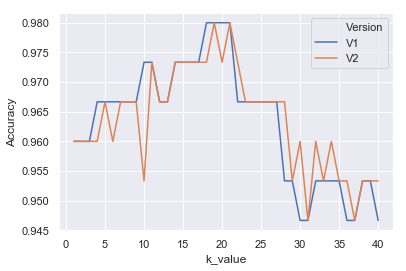

In [24]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted[results_melted['k_value']<=40])

One interesting insight that we can decipher from the two plots above is that for k-values lower than 'optimal', version 1 of our KNN algorithm tends to perform better (when there are discrepencies).  But once k surpasses the 'optimal' value, version 2 of our KNN algorithms tends to perform better (again, where there are discrepencies).  This makes sense since version 1 is essentially increasing the k value for records with ties, and for k values less than ~20, and increase in k typically increases accuracy.  Whereas for k values greater than ~20, increases in k typically reduce accuracy.

Peak accuracy is easier to see here, between 15 and 25.  We filter the plot further...

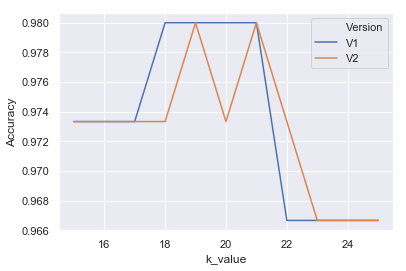

In [25]:
plt.figure()
sns.set(style="darkgrid")
sns.lineplot(x='k_value', y='Accuracy', hue = 'Version', data = results_melted[(results_melted['k_value']>=15) & (results_melted['k_value']<=25)])

__Extra Credit #1:__  Which K is best in terms of miss-classification?  A k value of 19 appears to be *an* optimal value of k with both KNN algorithm versions achieving 98% accuracy and without increasing k unecessarily (to 21).

In addition, we'll look more closely as the V1 version as it is less volatile than V2.

In [26]:
best_v_and_k = 'v1_' + 'k_is_' + str(19)
iris_df_results[best_v_and_k].value_counts()

True     147
False      3
Name: v1_k_is_19, dtype: int64

Here we sort our results df by our 'best' chosen algorithm, V1 with k = 19. We sort so that the falsely predicted records appear last and will be plotted last, ensuring they are not hiddent by records with similar feature values and we can see them in the subsequent plots.

In [45]:
iris_df_results = iris_df_results.sort_values(best_v_and_k, ascending = False)

Here we come back to our original plots of the iris dataset, but this time we have 'style' represent the actual target value, and 'hue' represent if we correctly predicted the record's target class.

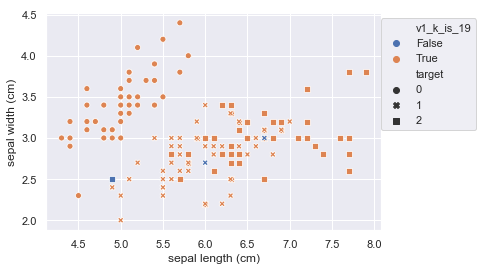

In [46]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data=iris_df_results, x='sepal length (cm)', y='sepal width (cm)', hue=best_v_and_k, style='target')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')

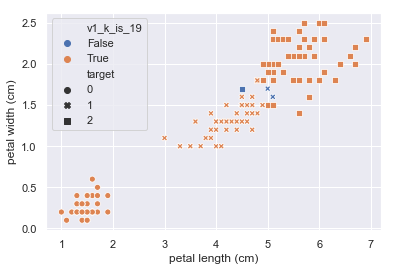

In [47]:
plt.figure()
sns.set(style="darkgrid")
sns.scatterplot(data=iris_df_results, x='petal length (cm)', y='petal width (cm)', hue=best_v_and_k, style='target')

It's not surprising that the data points in blue were falsely predicted as they are in 'border' regions of their classes, more easily seen in the second 'petals' plot. The falsely predicted predicted record with an actual 'target' value of 2, represented as a square is particularly unsurprising given its position in the first 'sepal' plot.

Overall, though, KNN performed remarkably well (in-sample) on this dataset so it is no wonder it is regarded as a pretty powerful and easy to implement algorithm.

__Extra Credit #2:__  In what ways does this implementation differ from those available in the scikit-learn package?

Aside from the precise data structure and code used, in terms of differences that could generate different results, scikit-learn's KNN classifiers still differ from this implementation in a number of ways
1. When 'weights' (see point #2 below) are uniform, as far as I'm able to decipher, scikit-learn's knn classifier algorithm breaks ties purely by looking at the order of records within the existing dataframe.  Thus, it will break the tie based on the class of whichever of the 'winning' neighbors appears first in the Dataframe.
2. scikit-learn provides an option to use weights in its classifier algorithm.  By default the weights are 'uniform' across all records which is generally how our algorithm performs its calculations as well.  However, there is an option (weights = 'distance') to weight the 'majority rule' of the k closest neighbors, assigning each potential class value the sum of the inverse of the distances between the record we're trying to predict and each of its neighbors with that class.  The closer the neighbor, the the larger the weight assigned to its class value instead of just using a count of each neighbor (a weight of '1') for each class.  This is essentially the methodology that was used solely for tie-breaking in Version 2 of our KNN algorithm.
3. Lastly, scikit-learn provides an alternative method for determining the set of neighbors for 'KNN', appropriately called "RadiusNeighborsClassifier" instead of "KNeighborsClassifier".  Instead of taking the k neighbors with the smallest euclidean distance, you can also determine a multidimensial 'radius' or distance around the record to predict and include only and all neighbor records within that distance.  With this implementation, 'k' will typically vary from one record to another.  With records nested within and near a large group of other records, k will be large, whereas for records far away from most other records, k will be small.

*Sources for EC #2:* 
1. *https://stats.stackexchange.com/questions/144718/how-does-scikit-learn-resolve-ties-in-the-knn-classification*
2. *https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification*